# Investigación Corta #2

## Preparando los datos
Para esta investigación se utiliza una base de datos la cual contiene informaicón de los pagos realizados de clientes en Taiwán y compara la precisión predictiva de la probabilidad de incumplimiento entre los seis métodos de extracción de datos.
La base de datos fue limpiad. Se reemplazaron los números por etiquetas en columnas categóricas (educación, matrimonio, etc.), se eliminaron las columnas derivadas y se cambiaron algunos nombres de columna. Obteniendo una base de datos con 16 entradas y 30000 casos.

Entradas:
- Edad, educación, matrimonio, sexo.
- Límite de crédito.
- Factura actual.
- Últimos 5 montos de cuentas.
- Últimos 5 pagos.

Al tener una base de datos sana, el siguiente paso es analizar la información que esta contienen. Esto se puede hacer por medio del siguiente codigo:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
Sex             30000 non-null object
Education       30000 non-null object
Marriage        30000 non-null object
Age             30000 non-null int64
Credit_Limit    30000 non-null int64
Current_Bill    30000 non-null int64
Prev_Bill1      30000 non-null int64
Prev_Bill2      30000 non-null int64
Prev_Bill3      30000 non-null int64
Prev_Bill4      30000 non-null int64
Prev_Bill5      30000 non-null int64
Paid_Amt1       30000 non-null int64
Paid_Amt2       30000 non-null int64
Paid_Amt3       30000 non-null int64
Paid_Amt4       30000 non-null int64
Paid_Amt5       30000 non-null int64
Default         30000 non-null int64
dtypes: int64(14), object(3)
memory usage: 3.9+ MB
None


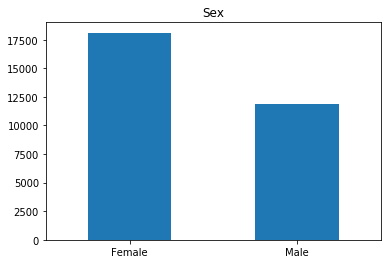

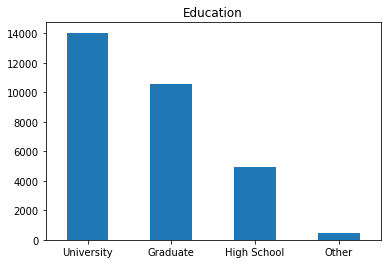

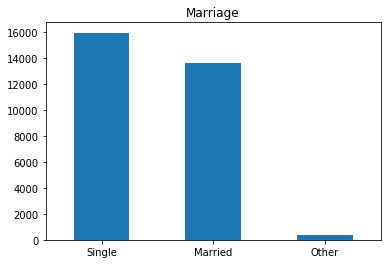

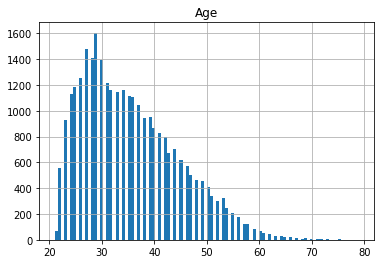

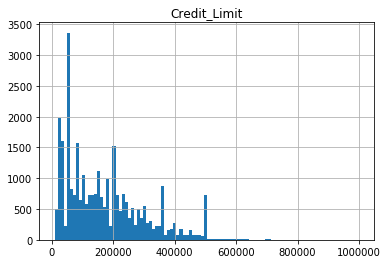

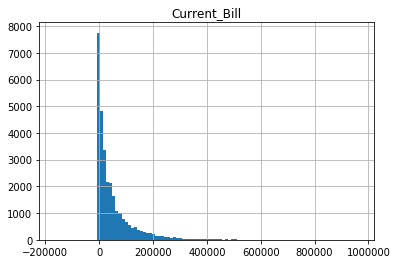

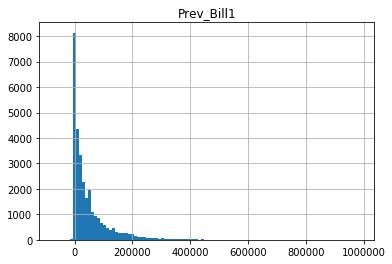

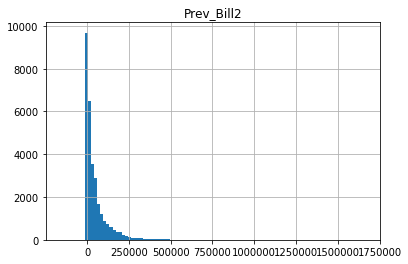

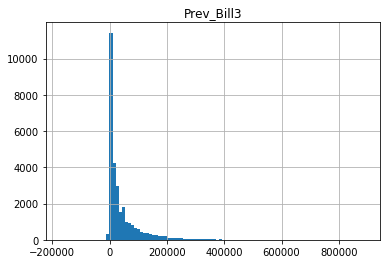

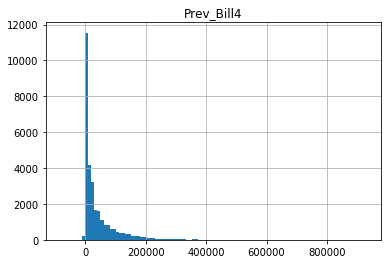

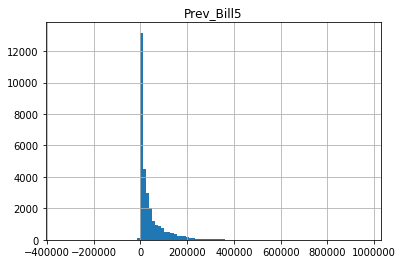

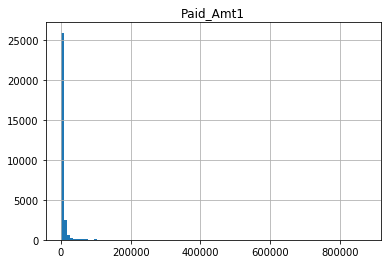

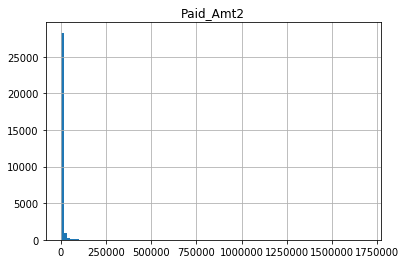

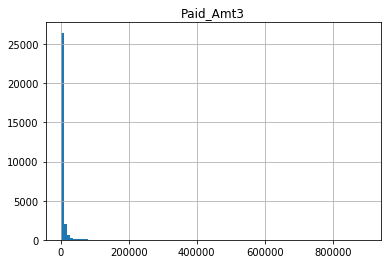

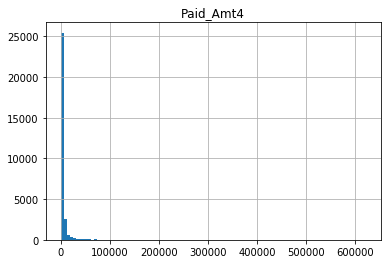

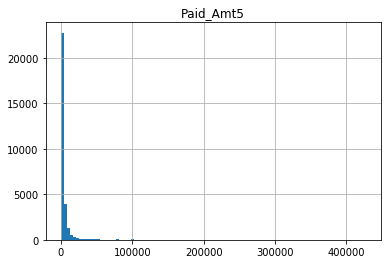

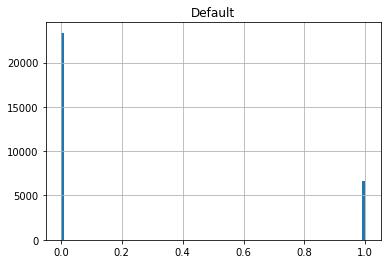

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("credit_card_default.csv", header=0)

# Print the dataframe info
print(df.info())

# Go through all the columns
for col in df.columns:
    if df[col].dtype == "object":
        # If categorical, do a count bar plot
        lm = pd.value_counts(df[col]).plot.bar()
        lm.set_xticklabels(lm.get_xticklabels(),rotation=0)
        plt.title(col)
        plt.show()

    else:
        # If numerical, do a histogram
        df.hist(column=col, bins=100)
        plt.title(col)
        plt.show()

El siguiente paso es dividir de forma aleatoria los datos en datos de entrenamiento y datos para las pruebas. Para esto usaremos una proporción 80/20 y guardaremos los datos dividios en un archivo pickle para facilidad del procesamiento.

In [61]:
import pickle
import sklearn.preprocessing

# Encode all categorical variables
df = pd.get_dummies(df, prefix_sep="_", drop_first=True)

# Shuffle the data and divide into training and test sets
total_len = len(df)
train_len = int(total_len*0.8)
test_len = total_len - train_len

reorder_map = np.random.permutation(total_len)
train_idx_map = reorder_map[0:train_len]
test_idx_map = reorder_map[train_len:]

train_set = df.iloc[train_idx_map]
test_set = df.iloc[test_idx_map]

# Separate labels from the rest of the input features
train_labels = train_set["Default"]
train_data = train_set.drop(columns="Default")

test_labels = test_set["Default"]
test_data = test_set.drop(columns="Default")

print("Train data:")
print(train_data.info())
print("Test data:")
print(test_data.info())

Train data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 2060 to 28384
Data columns (total 19 columns):
Age                      24000 non-null int64
Credit_Limit             24000 non-null int64
Current_Bill             24000 non-null int64
Prev_Bill1               24000 non-null int64
Prev_Bill2               24000 non-null int64
Prev_Bill3               24000 non-null int64
Prev_Bill4               24000 non-null int64
Prev_Bill5               24000 non-null int64
Paid_Amt1                24000 non-null int64
Paid_Amt2                24000 non-null int64
Paid_Amt3                24000 non-null int64
Paid_Amt4                24000 non-null int64
Paid_Amt5                24000 non-null int64
Sex_Male                 24000 non-null uint8
Education_High School    24000 non-null uint8
Education_Other          24000 non-null uint8
Education_University     24000 non-null uint8
Marriage_Other           24000 non-null uint8
Marriage_Single          24000 non-null uint8
dt

Podemos tambien utilizar histogramas para verificar la division de nuestros datos de forma de estar seguros sobre la consistencia de los sets de datos

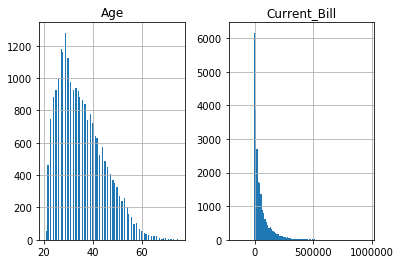

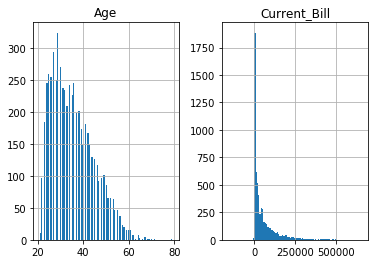

In [62]:
# Show a histogram of a few variables in the split sets
train_data.hist(column=["Age", "Current_Bill"], bins=hist_num_bins)
test_data.hist(column=["Age", "Current_Bill"], bins=hist_num_bins)
plt.show()

Como ultimo paso almacenamos los datos para futuros experimentos. Para esto utilizamos un archivo pickle ya que python nos da facilidades de manupulación con este formato.

In [63]:
# Extract the ndarrays from the dataframes
train_data_ndarray = train_data.values.astype("float64")
test_data_ndarray = test_data.values.astype("float64")

# Train a standard scaler from the training data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(train_data_ndarray)

# Scale both the training and test data
train_data_scaled_ndarray = scaler.transform(train_data_ndarray)
test_data_scaled_ndarray = scaler.transform(test_data_ndarray)

# Re-create Pandas dataframes with the scaled data
train_data_scaled = pd.DataFrame(train_data_scaled_ndarray, columns = train_data.columns)
test_data_scaled = pd.DataFrame(test_data_scaled_ndarray, columns = test_data.columns)

# Archive the training and test datasets into a pickle file
with open("credit_card_default_dataset.pickle", 'wb') as f:
      pickle.dump([train_data_scaled, train_labels, test_data_scaled, test_labels], \
                  f, pickle.HIGHEST_PROTOCOL)

## Regresion Logística
Para problemas de clasificación, un modelo lineal no se ajusta exactamente a lo que se quiere. Se quiere algo que produzca una salida cercana a 0 o a 1, pero no en el medio. La regresión logística utiliza una función en forma de S que está más cerca de lo que se necesita.

La regresión logística también se conoce en la literatura como regresión logit, clasificación de máxima entropía (MaxEnt) o el clasificador log-lineal. En este modelo, las probabilidades que describen los posibles resultados de un solo ensayo se modelan utilizando una función logística.

Se inicia con una combinación lineal de las entradas. Agrega una función logística como la función de "activación"

### Regresion lineal en Scikit-Learn

In [65]:
# Load the training and test data from the Pickle file
with open("credit_card_default_dataset.pickle", "rb") as f:
      train_data, train_labels, test_data, test_labels = pickle.load(f)

# Select columns of interest
cols = train_data.columns

# Create and train a new logistic regression classifier
model = sklearn.linear_model.LogisticRegression(\
        solver='newton-cg', \
        tol=1e-4, max_iter=1000)

# Train it with the training data and labels
model.fit(train_data[cols], train_labels)

# Print some results
print("Iterations used: \t", model.n_iter_)
print("Intercept: \t", model.intercept_)
print("Coeffs: ", model.coef_)
print("")

# Get the prediction probabilities
Y_pred_proba = model.predict_proba(test_data[cols])[::,1]

# Binarize the predictions by comparing to a threshold
threshold = 0.3
print("Threshold: ", threshold)
print("")
Y_pred = (Y_pred_proba > threshold).astype(np.int_)

# Compute the statistics
cmatrix = sklearn.metrics.confusion_matrix(test_labels, Y_pred)
print("Confusion Matrix:")
print(cmatrix)
print("")

accuracy = sklearn.metrics.accuracy_score(test_labels, Y_pred)
print("Accuracy: \t{:.3f}".format(accuracy))

precision = sklearn.metrics.precision_score(test_labels, Y_pred)
print("Precision: \t{:.3f}".format(precision))

recall = sklearn.metrics.recall_score(test_labels, Y_pred)
print("Recall: \t{:.3f}".format(recall))

Iterations used: 	 [14]
Intercept: 	 [-1.41046437]
Coeffs:  [[ 0.04112996 -0.38765674 -0.55371104  0.3241196   0.11909581  0.02378434
   0.12349787  0.1942538  -0.46522205 -0.36151565 -0.13183045 -0.10136328
  -0.08882225  0.07876373  0.00326941 -0.16796723  0.01034957 -0.02138419
  -0.10266606]]

Threshold:  0.3

Confusion Matrix:
[[3932  701]
 [ 911  456]]

Accuracy: 	0.731
Precision: 	0.394
Recall: 	0.334


Los primeros resultados nos arrojan, que se con 14 iterraciones el algoritmo convergio, tambien se emuestran los coeficientes resultantes en caso de que se quieran analizar. Utilizando un threshold de 0.3 se obtiene una exactitud de 73.7% con una presicion de 37.6% y un recall de 34%.
Para este modelo, se puede graficar un comparación entre presición y recall la cual no dara el threshold que podemos utilizar segun el umbral que se quiera dar mas importancia. Lo ideal es el equilibrio entre la presición y el recall.

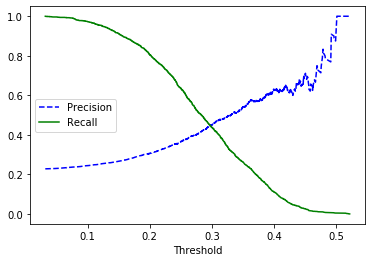

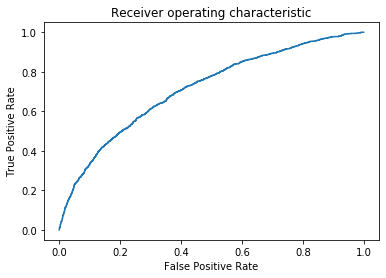

Test AUC score: 	0.714
Training AUC score: 	0.819


In [83]:
# Get the prediction probabilities
Y_pred_proba = model.predict_proba(test_data[cols])[::,1]

# Compute a precision & recall graph
precisions, recalls, thresholds = \
    sklearn.metrics.precision_recall_curve(test_labels, Y_pred_proba)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="center left")
plt.xlabel("Threshold")
plt.show()

# Plot a ROC curve (Receiver Operating Characteristic)
# Compares true positive rate with false positive rate
fpr, tpr, _ = sklearn.metrics.roc_curve(test_labels, Y_pred_proba)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
print("Test AUC score: \t{:.3f}".format(auc_score))

# Predict new labels for training data
Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
auc_score_training = sklearn.metrics.roc_auc_score(\
    train_labels, Y_pred_proba_training)
print("Training AUC score: \t{:.3f}".format(auc_score_training))

Otra forma de obtener una medida de calidas del clasificador es mediante la comparación de la tasa positiva verdadera con la tasa positiva falsa donde el área bajo la curva (AUC) proporciona esta medida. Donde a mayor area bajo la curva, mejor rendimiento del modelo.

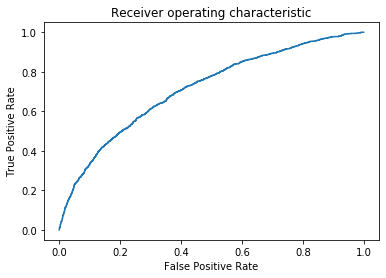

AUC score: 0.714
Training AUC score: 0.819


In [84]:
# Plot a ROC curve (Receiver Operating Characteristic)
# Compares true positive rate with false positive rate
fpr, tpr, _ = sklearn.metrics.roc_curve(test_labels, Y_pred_proba)
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
print("AUC score: {:.3f}".format(auc_score))

# Predict new labels for training data
Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
auc_score_training = sklearn.metrics.roc_auc_score(\
    train_labels, Y_pred_proba_training)
print("Training AUC score: {:.3f}".format(auc_score_training))


## k Nearest Neighors 
Un clasificador basado en instancia donde se compara cada punto de prueba con los K puntos más cercanos utilizando una distancia euclidiana con respecto a cada característica.Se debe estandarizar la escala de las acracteristicas con el objetivo de tener una comparación con equidad donde se utiliza el vato mayoritario para realizar la clasificaicón. Es mejor para problemas con pocas caracteristicas.

### K-Nearest Neighbors en Scikit-Learn
Es necesario importar la biblioteca y adecuar nuestro modelo anterior a de K-Nearest Neighbors.Para buscar la mayor presición de nuestro modelo calcularemos utilizando desde 10 n_neighbors hasta 100. variando los datos de 10 en 10.

In [56]:
import sklearn.neighbors

for idx in range(10):
    num = 10+(idx*10)
    print("")
    print("min_samples_leaf: {:6d}"\
          .format(num))
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=num)
    
    # Train it with the training data and labels
    model.fit(train_data[cols], train_labels)

    # Get prediction probabilities
    Y_pred_proba = model.predict_proba(test_data[cols])[::,1]
    
    auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
    print("Test AUC score: \t{:.3f}".format(auc_score))

    # Predict new labels for training data
    Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
    auc_score_training = sklearn.metrics.roc_auc_score(\
    train_labels, Y_pred_proba_training)
    print("Training AUC score: \t{:.3f}".format(auc_score_training))


min_samples_leaf:     10
Test AUC score: 	0.624
Training AUC score: 	0.767

min_samples_leaf:     20
Test AUC score: 	0.633
Training AUC score: 	0.724

min_samples_leaf:     30
Test AUC score: 	0.641
Training AUC score: 	0.706

min_samples_leaf:     40
Test AUC score: 	0.643
Training AUC score: 	0.695

min_samples_leaf:     50
Test AUC score: 	0.641
Training AUC score: 	0.687

min_samples_leaf:     60
Test AUC score: 	0.639
Training AUC score: 	0.683

min_samples_leaf:     70
Test AUC score: 	0.639
Training AUC score: 	0.679

min_samples_leaf:     80
Test AUC score: 	0.642
Training AUC score: 	0.676

min_samples_leaf:     90
Test AUC score: 	0.642
Training AUC score: 	0.672

min_samples_leaf:    100
Test AUC score: 	0.642
Training AUC score: 	0.669


Al utilizar 50 numeros vecinos obtenemos la mejor area debajo la curva tanto para los datos de entrenamiento como para los datos de prueba.

## Decision Trees
Los árboles de decisión son un método de aprendizaje supervisado no paramétrico utilizado para la clasificación y la regresión. El objetivo es crear un modelo que predice el valor de una variable objetivo mediante el aprendizaje de reglas de decisión simples deducidas de las características de los datos.

### Decision Trees en Scikit-Learn
Es necesario importar la biblioteca y adecuar nuestro modelo anterior a de Decision Trees.Para buscar la mayor presición de nuestro modelo calcularemos utilizando desde 50 min_samples_leaf hasta 500. variando los datos de 50 en 50.

In [55]:
import sklearn.tree

for idx in range(10):

    num = 50+(idx*50)
    print("")
    print("min_samples_leaf: {:6d}"\
          .format(num))
    
    # Create and train a Decision Tree classifier
    model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=num)

    # Train it with the training data and labels
    model.fit(train_data[cols], train_labels)

    # Get prediction probabilities
    Y_pred_proba = model.predict_proba(test_data[cols])[::,1]
    
    auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
    print("Test AUC score: \t{:.3f}".format(auc_score))

    # Predict new labels for training data
    Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
    auc_score_training = sklearn.metrics.roc_auc_score(\
                                                       train_labels, Y_pred_proba_training)
    print("Training AUC score: \t{:.3f}".format(auc_score_training))


min_samples_leaf:     50
Test AUC score: 	0.685
Training AUC score: 	0.796

min_samples_leaf:    100
Test AUC score: 	0.692
Training AUC score: 	0.764

min_samples_leaf:    150
Test AUC score: 	0.703
Training AUC score: 	0.748

min_samples_leaf:    200
Test AUC score: 	0.704
Training AUC score: 	0.741

min_samples_leaf:    250
Test AUC score: 	0.704
Training AUC score: 	0.734

min_samples_leaf:    300
Test AUC score: 	0.704
Training AUC score: 	0.730

min_samples_leaf:    350
Test AUC score: 	0.701
Training AUC score: 	0.727

min_samples_leaf:    400
Test AUC score: 	0.700
Training AUC score: 	0.721

min_samples_leaf:    450
Test AUC score: 	0.702
Training AUC score: 	0.717

min_samples_leaf:    500
Test AUC score: 	0.700
Training AUC score: 	0.715


Utilizando un numero de 200 hojas obtenemos el mejor resultado. Donde se tiene una mayor area bajo la curva para nuestros datos de prueba.


## Random Forests
Cada árbol del conjunto se construye a partir de una muestra extraída con reemplazo del conjunto de entrenamiento. Además, al dividir un nodo durante la construcción del árbol, la división elegida ya no es la mejor división entre todas las características. En cambio, la división que se escoge es la mejor división entre un subconjunto aleatorio de las características. Como resultado de esta aleatoriedad, el sesgo del bosque generalmente aumenta ligeramente pero, debido a la promediación, su varianza también disminuye, generalmente más que compensando el aumento del sesgo, por lo que se obtiene un mejor modelo en general.

### Random Forests en Scikit-Learn
Es necesario importar la biblioteca y adecuar nuestro modelo anterior a de Decision Trees. Para buscar la mayor presición de nuestro modelo calcularemos utilizando desde 20 n_estimators hasta 200, variando los datos de 20 en 20.

In [77]:
import sklearn.ensemble

for idx in range(1,11,1):
    num = idx*20
    model = sklearn.ensemble.RandomForestClassifier(\
        n_estimators=num,
        min_samples_leaf=350)

    # Train it with the training data and labels
    model.fit(train_data[cols], train_labels)

    # Get prediction probabilities
    Y_pred_proba = model.predict_proba(test_data[cols])[::,1]
    
    print("")
    print("n_estimators: {:6d}".format(num))
    auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
    print("Test AUC score: \t{:.3f}".format(auc_score))

    # Predict new labels for training data
    Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
    auc_score_training = sklearn.metrics.roc_auc_score(\
                                                       train_labels, Y_pred_proba_training)
    print("Training AUC score: \t{:.3f}".format(auc_score_training))


n_estimators:     20
Test AUC score: 	0.709
Training AUC score: 	0.728

n_estimators:     40
Test AUC score: 	0.711
Training AUC score: 	0.731

n_estimators:     60
Test AUC score: 	0.712
Training AUC score: 	0.733

n_estimators:     80
Test AUC score: 	0.713
Training AUC score: 	0.735

n_estimators:    100
Test AUC score: 	0.713
Training AUC score: 	0.735

n_estimators:    120
Test AUC score: 	0.712
Training AUC score: 	0.733

n_estimators:    140
Test AUC score: 	0.713
Training AUC score: 	0.734

n_estimators:    160
Test AUC score: 	0.712
Training AUC score: 	0.733

n_estimators:    180
Test AUC score: 	0.712
Training AUC score: 	0.734

n_estimators:    200
Test AUC score: 	0.712
Training AUC score: 	0.734


Usando 140 n_estimators se logra el mejor resultado. Pero para este modelo tenemos dos variantes, que pasa si iteramos sobre el numero de hojas para mejorar los resultados. Utilizando desde 2 min_samples_leaf hasta 20, variando los datos de 2 en 2.

In [78]:
for idx in range(1,11,1):
    num = idx*2
    model = sklearn.ensemble.RandomForestClassifier(\
        n_estimators=14,
        min_samples_leaf=num)

    # Train it with the training data and labels
    model.fit(train_data[cols], train_labels)

    # Get prediction probabilities
    Y_pred_proba = model.predict_proba(test_data[cols])[::,1]
    
    print("")
    print("min_samples_leaf: {:6d}".format(num))
    auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
    print("Test AUC score: \t{:.3f}".format(auc_score))

    # Predict new labels for training data
    Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
    auc_score_training = sklearn.metrics.roc_auc_score(\
                                                       train_labels, Y_pred_proba_training)
    print("Training AUC score: \t{:.3f}".format(auc_score_training))


min_samples_leaf:      2
Test AUC score: 	0.689
Training AUC score: 	0.996

min_samples_leaf:      4
Test AUC score: 	0.706
Training AUC score: 	0.976

min_samples_leaf:      6
Test AUC score: 	0.711
Training AUC score: 	0.952

min_samples_leaf:      8
Test AUC score: 	0.714
Training AUC score: 	0.930

min_samples_leaf:     10
Test AUC score: 	0.718
Training AUC score: 	0.912

min_samples_leaf:     12
Test AUC score: 	0.713
Training AUC score: 	0.896

min_samples_leaf:     14
Test AUC score: 	0.718
Training AUC score: 	0.886

min_samples_leaf:     16
Test AUC score: 	0.718
Training AUC score: 	0.873

min_samples_leaf:     18
Test AUC score: 	0.724
Training AUC score: 	0.867

min_samples_leaf:     20
Test AUC score: 	0.715
Training AUC score: 	0.855


Usando la combinación de 140 n_estimators y 14 min_samples_leaf se obtine los mejores resultados.

## Ensemble Classifiers
El objetivo de los métodos de conjunto es combinar las predicciones de varios estimadores base construidos con un algoritmo de aprendizaje dado para mejorar la generalización / robustez en un estimador único. Por lo tanto se va a combinar 3 de los algoritmos descritos anteriormente:
- Logistic regression
- K-Nearest neighbors
- Random forest

Se utilizan los parametros obtenidos en anteriormente

In [80]:
# Create a logistic regression classifier
logistic = sklearn.linear_model.LogisticRegression(\
        solver='newton-cg', \
        tol=1e-4, max_iter=1000)

# Create a k-Nearest neighbors classifier
kNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=50)

# Create a Random Forest classifier
randforest = sklearn.ensemble.RandomForestClassifier(\
    n_estimators=140,
    min_samples_leaf=14)


y se combina  los 3 clasificadores por medio de la instrucción utilizando un voto "suave".

In [81]:
# Create a voting ensemble of classifiers
model = sklearn.ensemble.VotingClassifier(
    estimators=[('logistic', logistic),
                ('kNN', kNN),
                ('randforest', randforest),
                ],voting='soft')

# Train it with the training data and labels
model.fit(train_data[cols], train_labels)

# Get prediction probabilities
Y_pred_proba = model.predict_proba(test_data[cols])[::,1]

auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
print("Test AUC score: \t{:.3f}".format(auc_score))

# Predict new labels for training data
Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
auc_score_training = sklearn.metrics.roc_auc_score(\
    train_labels, Y_pred_proba_training)
print("Training AUC score: \t{:.3f}".format(auc_score_training))

Test AUC score: 	0.714
Training AUC score: 	0.819


Se obtiene un resultado de 71.4% con los datos de prueba. Al realizar la compración obtenemos:
- Regresion Logística: 65.5%
- k Nearest Neighors: 64.1%
- Decision Trees: 70.4%
- Random Forests: 71.8%

Con los cual vemos que mejora a 3 de los metodos de clasificación

### AdaBoost
El principio básico de AdaBoost es ajustarse a una secuencia de aprendices débiles en versiones modificadas repetidamente de los datos.

### AdaBoost en Scikit-Learn
Para buscar la mayor presición de nuestro modelo calcularemos utilizando desde 50 n_estimators hasta 500, variando los datos de 50 en 50.

In [95]:
for idx in range(1,11,1):
    num = idx*50

    # Create adaboost classifer object
    model = AdaBoostClassifier(n_estimators=num,learning_rate=1)

    # Train it with the training data and labels
    model.fit(train_data[cols], train_labels)

    # Get prediction probabilities
    Y_pred_proba = model.predict_proba(test_data[cols])[::,1]

    print("")
    print("n_estimators: {:6d}".format(num))
    auc_score = sklearn.metrics.roc_auc_score(test_labels, Y_pred_proba)
    print("Test AUC score: \t{:.3f}".format(auc_score))

    # Predict new labels for training data
    Y_pred_proba_training = model.predict_proba(train_data[cols])[::,1]
    auc_score_training = sklearn.metrics.roc_auc_score(\
        train_labels, Y_pred_proba_training)
    print("Training AUC score: \t{:.3f}".format(auc_score_training))


n_estimators:     50
Test AUC score: 	0.720
Training AUC score: 	0.734

n_estimators:    100
Test AUC score: 	0.726
Training AUC score: 	0.741

n_estimators:    150
Test AUC score: 	0.726
Training AUC score: 	0.744

n_estimators:    200
Test AUC score: 	0.725
Training AUC score: 	0.747

n_estimators:    250
Test AUC score: 	0.725
Training AUC score: 	0.749

n_estimators:    300
Test AUC score: 	0.725
Training AUC score: 	0.752

n_estimators:    350
Test AUC score: 	0.725
Training AUC score: 	0.754

n_estimators:    400
Test AUC score: 	0.725
Training AUC score: 	0.756

n_estimators:    450
Test AUC score: 	0.724
Training AUC score: 	0.757

n_estimators:    500
Test AUC score: 	0.724
Training AUC score: 	0.759


Usando la combinación de 150 n_estimators se obtine los mejores resultados. Se puede observar que apartir de 200 n_estimators no se mejora los datos del test, si no los de training lo cual indica que se sobre entrena la red para memorizar los datos de entrenamiento.